# iRecognize: Visual Intelligence Made Easy

<p align="center">
  <img src="https://user-images.githubusercontent.com/55694345/134716978-c51f82f2-92d4-419b-8dbf-bfb1e0646eb6.png" width=50% height=50% />
</p><br>

Project for the "Technologies for Andvanced Programming" course @ University of Catania, september 2021.

ℹ️ this project aims, with a with a custom trained prediction model, to make the environment around you more understandable. <br>
⚠️ this bot hasn’t an active server, it works only if you download and start the source code. <br>
🔓 this is an open-source project, the code is downloadable and editable free of charge. <br>

For any information, doubts or questions feel free to write to me!

# 1. Training Phase

## 1.1 Install the client library

In [1]:
# pip install azure-cognitiveservices-vision-customvision

## 1.2 Create a new python application

In [1]:
import json
  
# Open JSON file
with open("C:/Users/Davide/Desktop/TAP/COCO Update/instances_val2017.json") as json_file:
    data = json.load(json_file)
    
data.keys()

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

## Classes to be trained:

In [3]:
data["categories"]

[{'supercategory': 'person', 'id': 1, 'name': 'person'},
 {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'vehicle', 'id': 3, 'name': 'car'},
 {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'},
 {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'},
 {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'},
 {'supercategory': 'vehicle', 'id': 7, 'name': 'train'},
 {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'},
 {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'},
 {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'},
 {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'},
 {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'},
 {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'},
 {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'},
 {'supercategory': 'animal', 'id': 16, 'name': 'bird'},
 {'supercategory': 'animal', 'id': 17, 'name': 'cat'},
 {'supercategory': 'animal', 'id': 18, 'name': 'dog'},

In [3]:
from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient
from azure.cognitiveservices.vision.customvision.training.models import ImageFileCreateBatch, ImageFileCreateEntry, Region
from msrest.authentication import ApiKeyCredentials
from PIL import Image
from skimage import io
import os, time, uuid
import urllib.request
import requests
import numpy as np

# Replace with valid values
ENDPOINT = "https://southcentralus.api.cognitive.microsoft.com/"
training_key = "aced45df217b40c29c887a160d609ff4"
prediction_key = "aced45df217b40c29c887a160d609ff4"
prediction_resource_id = "/subscriptions/51a91f45-a201-4329-947c-d46fb0565938/resourceGroups/davidecas/providers/Microsoft.CognitiveServices/accounts/davidecas"

credentials = ApiKeyCredentials(in_headers={"Training-key": training_key})
trainer = CustomVisionTrainingClient(ENDPOINT, credentials)
prediction_credentials = ApiKeyCredentials(in_headers={"Prediction-key": prediction_key})
predictor = CustomVisionPredictionClient(ENDPOINT, prediction_credentials)

publish_iteration_name = "detectModel"

# Find the object detection domain
obj_detection_domain = next(domain for domain in trainer.get_domains() if domain.type == "ObjectDetection" and domain.name == "General")

# Create a new project
print ("Creating project...")
# Use uuid to avoid project name collisions.
project = trainer.create_project(str(uuid.uuid4()), domain_id=obj_detection_domain.id)

###

n_categories = len(data["categories"])
category_ids = []
sel_categories = []
for name in range(n_categories): sel_categories.append(data["categories"][name]["name"])

for i in range(n_categories):
    for j in range(n_categories):
        if sel_categories[i] == data["categories"][j]["name"]:
            category_ids.append(data["categories"][j]["id"])
            break

###

n_entries = len(data["annotations"])
total_length = len(sel_categories)
progress = total_length

for x in range(len(category_ids)):
    
    # actual progress percentage
    progress -= 1
    actual_progress = str(100 - (progress * 100 / total_length))
    print("[" + actual_progress + "%] Adding class:", sel_categories[x])
    
    
    image_ids = []
    for j in range(n_entries):
        category_id = data["annotations"][j]["category_id"]

        if category_id == category_ids[x]:
            image_id = data["annotations"][j]["image_id"]
            image_ids.append(image_id)

    ###

    image_ids = np.unique(image_ids)
    image_indexes = [j for j, y in enumerate(data["images"]) if y["id"] in image_ids]

    ###

    urls = []
    bbox = []
    imgs = []

    for image_index in image_indexes:
        urls.append(data["images"][image_index]["coco_url"])
        image_id = data["images"][image_index]["id"]

        annotations = [y["bbox"] for y in data["annotations"] if (y["image_id"] == image_id) and (y["category_id"] == category_ids[x])]
        bbox.append(annotations)
        imgs.append(data["images"][image_index])

    # Make two tags in the new project
    new_tag = trainer.create_tag(project.id, sel_categories[x])

    # Go through the data table above and create the images
    print ("Uploading images...")

    tagged_images_with_regions = []

    for i in range(len(bbox)):
        bboxes = bbox[i]
        regions = []

        for box in bboxes:

            x,y,w,h = box

            x /= imgs[i]["width"]
            y /= imgs[i]["height"]
            w /= imgs[i]["width"]
            h /= imgs[i]["height"]

            regions.append(Region(tag_id=new_tag.id, left=x,top=y,width=w,height=h))

        tagged_images_with_regions.append(ImageFileCreateEntry(name=i, contents=requests.get(urls[i], stream=True).content, regions=regions))

        if len(tagged_images_with_regions) == 64:
            #print("Uploading...")
            upload_result = trainer.create_images_from_files(project.id, ImageFileCreateBatch(images=tagged_images_with_regions))
            if not upload_result.is_batch_successful:
                exit(-1)

            tagged_images_with_regions = []

    if len(tagged_images_with_regions) > 0: 
        #print("Uploading...")
        upload_result = trainer.create_images_from_files(project.id, ImageFileCreateBatch(images=tagged_images_with_regions))
        if not upload_result.is_batch_successful: exit(-1)

        tagged_images_with_regions = []

print ("Finished.")

Creating project...
[1.25%] Adding class: person
Uploading images...
[2.5%] Adding class: bicycle
Uploading images...
[3.75%] Adding class: car
Uploading images...
[5.0%] Adding class: motorcycle
Uploading images...
[6.25%] Adding class: airplane
Uploading images...
[7.5%] Adding class: bus
Uploading images...
[8.75%] Adding class: train
Uploading images...
[10.0%] Adding class: truck
Uploading images...
[11.25%] Adding class: boat
Uploading images...
[12.5%] Adding class: traffic light
Uploading images...
[13.75%] Adding class: fire hydrant
Uploading images...
[15.0%] Adding class: stop sign
Uploading images...
[16.25%] Adding class: parking meter
Uploading images...
[17.5%] Adding class: bench
Uploading images...
[18.75%] Adding class: bird
Uploading images...
[20.0%] Adding class: cat
Uploading images...
[21.25%] Adding class: dog
Uploading images...
[22.5%] Adding class: horse
Uploading images...
[23.75%] Adding class: sheep
Uploading images...
[25.0%] Adding class: cow
Uploading i

# 2. Test Phase

In [25]:
# making the post request to get the last prediction
# getting the last tag, bbox and percentage prediction (with bboxes)

training_key = "aced45df217b40c29c887a160d609ff4"
iteration_id = "196bbbf8-942a-4811-871a-6601c2b22fd7"
project_id = "3836da1d-d9ff-4130-83eb-0bf0db618207"

def get_last_prediction(file_name):
    training_key = "aced45df217b40c29c887a160d609ff4"
    iteration_id = "196bbbf8-942a-4811-871a-6601c2b22fd7"
    project_id = "3836da1d-d9ff-4130-83eb-0bf0db618207"

    # Load Image
    img = Image.open("/usr/share/logstash/csv/photos/" + file_name)
    width, height = img.size

    # Azure Custom Vision API Connection
    url = f"https://southcentralus.api.cognitive.microsoft.com/customvision/v3.3/Training/projects/{project_id}/quicktest/image"

    headers = {
        # Request headers
        "Content-Type": "multipart/form-data",
        "Training-key": training_key,
    }

    params = {
        # Request parameters
        "iterationId": iteration_id,
        "store": "True",
    }

    resp = requests.post(url, headers=headers, params=params, data=open("/usr/share/logstash/csv/photos/" + file_name, "rb").read())
    r = resp.json()
    results = r["predictions"]
    n_predictions = len(results)

    tags_detected = []

    for i in range(n_predictions):
        probability = results[i]["probability"]

        if probability > 0.60:
            tagName = results[i]["tagName"]
            tags_detected.append(tagName)

            percentage = str(round((results[i]["probability"] * 100), 2)) + "%"

            x = results[i]["boundingBox"]["left"] * width
            y = results[i]["boundingBox"]["top"] * height
            w = results[i]["boundingBox"]["width"] * width
            h = results[i]["boundingBox"]["height"] * height

            # Display the image
            obj = plt.imshow(img)

            color = "#%06x" % random.randint(0, 0xFFFFFF)
            text = tagName + ": " + percentage

            # Add the patch to the Axes
            plt.gca().add_patch(Rectangle((x, y), w, h, linewidth=2, edgecolor=color, facecolor="none"))
            plt.text(x + w/2, y, text, fontsize=12.5/width*height, fontweight="bold", ha="center", va="bottom", fontfamily="monospace", color=color, bbox={"facecolor": "white", "alpha": 0.75, "pad": 2.5})

        else: break


    if len(tags_detected) == 0:
        tags_detected = "NO DETECTION"
        plt.savefig(f"/usr/share/logstash/csv/detected_photos/EMPTY_{file_name}", dpi=400)
        plt.figure()

    else:
        # Getting current axes
        a = plt.gca()
        a.axis("off")

        plt.savefig(f"/usr/share/logstash/csv/detected_photos/{file_name}", dpi=400)
        plt.figure()
        
    result = {"tags_detected" : tags_detected}

    return result

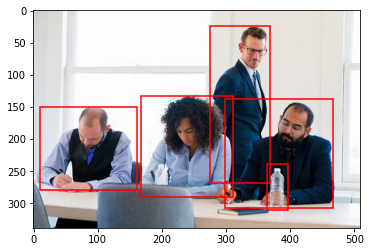

In [28]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image

image = Image.open("C:/Users/Davide/Desktop/TAP/photos/test1.jpg")
width, height = image.size

# Display the image
plt.imshow(Image.open("C:/Users/Davide/Desktop/TAP/photos/test1.jpg"))

for i in range(len(tags_detected)):
    x = coords[i][0] * width
    y = coords[i][1] * height
    w = coords[i][2] * width
    h = coords[i][3] * height

    # Add the patch to the Axes
    plt.gca().add_patch(Rectangle((x,y),w,h, linewidth=1.5, edgecolor='r',facecolor='none'))